# Mask Data Near Land 

Thanks [Dr. Mike Wood](https://github.com/mhwood)! 

In [19]:
import os
import glob

import numpy as np
import netCDF4 as nc4
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

from pyproj import Transformer
from scipy.interpolate import griddata
from scipy.spatial import cKDTree


import data_mask


# Custom colormaps
## Desaturate Turbo

In [20]:
def desaturate_colormap(colormap, factor):
    colors = colormap(np.linspace(0, 1, colormap.N))
    hsv_colors = plt.cm.colors.rgb_to_hsv(colors[:, :3])  # Extract RGB values and convert to HSV

    # Desaturate the colors
    hsv_colors[:, 1] *= factor

    # Convert back to RGB
    desaturated_colors = plt.cm.colors.hsv_to_rgb(hsv_colors)

    # Create a new colormap
    desaturated_colormap = LinearSegmentedColormap.from_list(
        f"{colormap.name}_desaturated",
        desaturated_colors,
        colormap.N
    )

    return desaturated_colormap

# Turbo colormap
turbo_colormap = plt.cm.get_cmap("turbo")

# Specify the desaturation factor (0.5 for 50% desaturation)
desaturation_factor = 0.85

# Create desaturated Turbo colormap
desaturated_turbo_colormap = desaturate_colormap(turbo_colormap, desaturation_factor)

# Store the desaturated colormap in a Python list
desaturated_colormap_list = desaturated_turbo_colormap(np.linspace(0, 1, 256)).tolist()


/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_41910/101177810.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  turbo_colormap = plt.cm.get_cmap("turbo")


## Creating custom colormaps from lists

In [21]:
# Convert RBG to hex
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

# Example: convert RGB to hex
R,G,B = [90, 88, 92]
hex_color = rgb_to_hex((R, G, B))
print(hex_color)

#5a585c


In [41]:
turbo_desat = colors.LinearSegmentedColormap.from_list("", desaturated_colormap_list)

# Define colors
ground_color = '#908a89'
peak_color = '#dfddd8'

# ex: 3 ways to define a color to the colormap list
outline_color = '#5a585c'   # hex color
# outline_color = rgb_to_hex((90, 88, 92))    # getting a hex color from rgb values list
# outline_color = 'black'     # color name


outline_ccolors = [outline_color, outline_color]
cmap_outline = mcolors.ListedColormap(outline_ccolors)

gl_color = [ground_color, peak_color]
cmap_gl = mcolors.ListedColormap(gl_color)

custom_colors = ['black','darkgrey']
custom_cmap2 = LinearSegmentedColormap.from_list('custom_cmap', custom_colors)

custom_colors = [ground_color, peak_color, 'white']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors)

## Get the BedMachine data
Start by reading in the BedMachine surface dataset and subset to your domain

In [28]:
# Disko Bay bounds (e.g.)
min_x = -463350
min_y = -2364239
max_x = -115044
max_y = -2049628

# Greenland bounds
# min_x, max_x = -652925.0, 879625.0
# min_y, max_y = -3384425.0,-632675.0

# Read in the BedMachine mask
ds = nc4.Dataset('/Users/tara/Documents/SJSU/MLML/Grids/BedMachine/BedMachineGreenland-v5.nc')
bm_x = ds.variables['x'][:]
bm_y = ds.variables['y'][:]
bm_mask = ds.variables['mask'][:, :]
ds.close()

# Subset to Disko Bay
x_indices = np.logical_and(bm_x>min_x, bm_x<max_x)
y_indices = np.logical_and(bm_y>min_y, bm_y<max_y)
bm_x = np.array(bm_x[x_indices]).astype(float)
bm_y = np.array(bm_y[y_indices]).astype(float)
bm_mask = bm_mask[y_indices, :]
bm_mask = bm_mask[:, x_indices]

# Read in the data

## Creating all of the August Maps
### Chl-a data is obtained and plotted by looping through August Files

In [12]:
source_folder = "/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed/august_data_128"
files = glob.glob(f"{source_folder}/*.nc")
files.sort()

x, y, data = data_mask.get_ds(files[0], var = 'chla')
mask = data_mask.make_distance_mask(data, x, y)

def run_all_august(files):
    for file in files:
        file_year = file.split('/')[-1].split('.')[0].split('_')[-1]
        print("Processing year {:s}".format(file_year), end='\r')

        x, y, data = data_mask.get_ds(file, var = 'chla')
        data = data_mask.mask_data(data, mask, threshold=1000)

        data = np.where(np.isnan(data), -1, data)

        # figsize = (7, 9.5) # no cbar
        figsize = (8, 10) # with cbar
        plt.figure(figsize=figsize, dpi=400)

        C = plt.pcolormesh(x, y, data, cmap=turbo_desat, vmin=0.5, vmax=4)
        plt.pcolormesh(x, y, outline_map, cmap=cmap_outline, alpha=0.9)
        plt.pcolormesh(bm_x, bm_y, bm_mask, cmap=cmap_gl, alpha=0.7)

        plt.xticks([])
        plt.yticks([])
        plt.title("August {:s}".format(file.split('/')[-1].split('.')[0].split('_')[-1]), fontsize=20, weight='bold')

        cbar = plt.colorbar(C)
        cbar.set_label('$mg/m^3$', size=16, weight='bold')  # Set colorbar label font size
        cbar.ax.tick_params(labelsize=16)  # Set tick label font size

        # Set color bar tick labels to bold
        for l in cbar.ax.yaxis.get_ticklabels():
            l.set_weight("bold")
            
        
        plt.gca().set_xlim(x.min(), x.max())
        plt.gca().set_ylim(y.min(), y.max())

        # plt.savefig("../plots/augustmaps/no_cbars/aug_mean_{:s}_map.png".format(file.split('/')[-1].split('.')[0].split('_')[-1]), dpi=400, transparent=True)
        plt.savefig("../plots/augustmaps/yes_cbars/aug_mean_{:s}_map.png".format(file_year), dpi=400, transparent=True)

        # plt.show()
        plt.close('all')

# UNCOMMENT TO Run
# run_all_august(files)

## Read in the Chlorophyll Data

In [25]:
std_file_path = '/Volumes/Seagate/CHANGES/data_repository/plots/chla_std.nc'
chlor_file_path = '/Volumes/Seagate/CHANGES/data_repository/plots/chla_mean.nc'
trend_path = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2'

ds = nc4.Dataset(chlor_file_path)
x = np.array(ds.variables['x'][:]).astype(float)
y = np.array(ds.variables['y'][:]).astype(float)
chlor_a = ds.variables['chla'][:, :]

ds = nc4.Dataset(std_file_path)
std = ds.variables['std'][:, :]

files = glob.glob(f"{trend_path}/*_rmse.nc")
ds = xr.open_mfdataset(files, combine='by_coords')
rmse = ds.variables['rsme'][:, :]
rmse = rmse.transpose("y", "x")

files = glob.glob(f"{trend_path}/*_slope.nc")
ds = xr.open_mfdataset(files, combine='by_coords')
slopes = ds.variables['trendline_slope'][:, :]
slopes = slopes.transpose("y", "x")

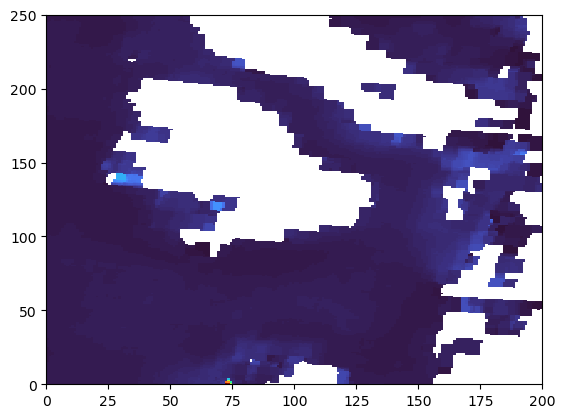

In [26]:
# test plot
plt.pcolormesh(chlor_a, cmap='turbo')
plt.show()

## Make a distance mask
Make a grid of distances from land.

In [29]:
# interpolate BedMachine to the grid as a starting point
bm_X, bm_Y = np.meshgrid(bm_x, bm_y)
X, Y = np.meshgrid(x, y)

# find the points corresponding to ice/land
land_indices = bm_mask.ravel()>0
land_x = bm_X.ravel()[land_indices]
land_y = bm_Y.ravel()[land_indices]

# make a mask to fill in
mask = np.zeros_like(chlor_a)

# Create a KDTree from the land points
tree = cKDTree(np.column_stack((land_x, land_y)))

# Calculate the distance to the closest land point for each point in the grid
distances, _ = tree.query(np.column_stack((X.ravel(), Y.ravel())))

# Reshape the distances array to the shape of the mask
mask = distances.reshape(mask.shape)

Plot the distance mask

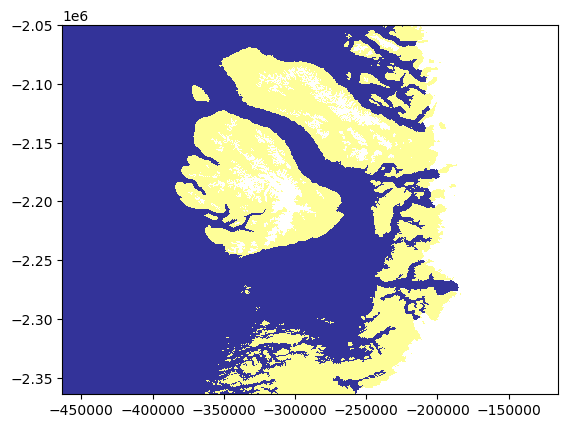

In [34]:
# Check the bed machine crop
plt.pcolormesh(bm_x, bm_y, bm_mask, cmap='terrain')
plt.show()
plt.close()

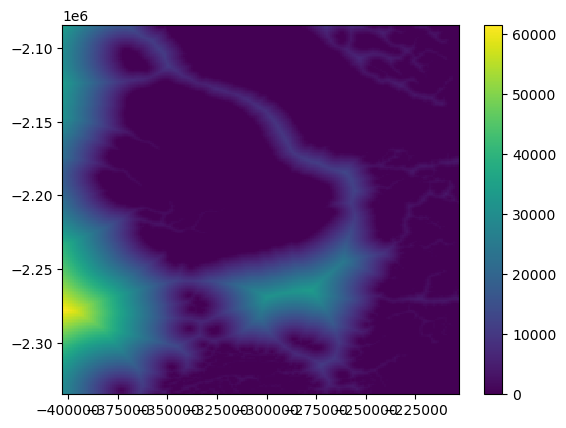

In [33]:
# check the mask

C = plt.pcolormesh(x, y, mask, shading='auto')
plt.colorbar(C)
plt.show()
plt.close('all')

Mask the data with the distance mask

In [35]:
# define a distance threshold
# adjust this as needed to eliminate most of the noise
distance_threshold = 1000 # 2km = 2000m
# distance_threshold = 15 # <- used 15m when plotting all of greenland 

# define the mask
distance_mask = mask<distance_threshold

# mask the data
chlor_masked = np.copy(chlor_a)
chlor_masked[distance_mask] = np.nan

# std_masked = np.copy(std)
# std_masked[distance_mask] = np.nan

# slopes_masked = np.copy(slopes)
# slopes_masked[distance_mask] = np.nan

# rmse_masked = np.copy(rmse)
# rmse_masked[distance_mask] = np.nan


# Get the bed machine data
bm_mask = bm_mask.astype(float)
bm_mask[bm_mask <= 0] = np.nan

# Get the outline mask map (becomes an outline of the masked data when plotted before (under) the bm_mask)
outline_map = np.where(distance_mask, 1, np.nan)

### Plot the masked data

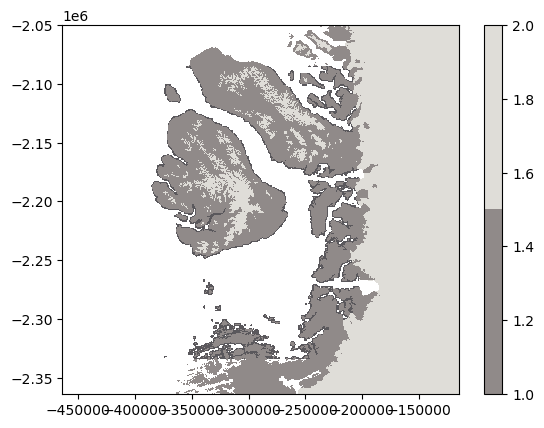

In [42]:
# test the mask and bm layer
# note the mask is smaller than the bm plot. which is hidden when we plot the data
plt.pcolormesh(x, y, outline_map, cmap=cmap_outline)
plt.pcolormesh(bm_x, bm_y, bm_mask, cmap=cmap_gl)
plt.colorbar()
plt.show()
plt.close('all')

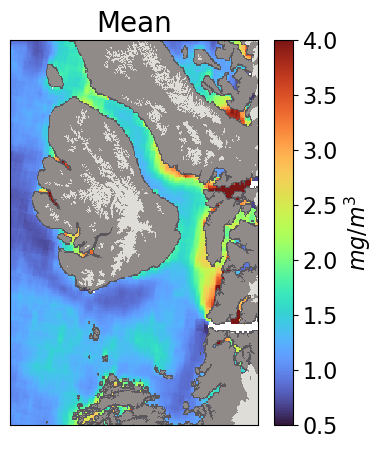

In [43]:
# Test the plot with mask and bedmachine layer
figsize = (4, 5)
plt.figure(figsize=figsize)
plt.pcolormesh(x, y, outline_map, cmap=cmap_outline)
plt.pcolormesh(bm_x, bm_y, bm_mask, cmap=cmap_gl) #, alpha=0.8)
C = plt.pcolormesh(x, y, chlor_masked, cmap=turbo_desat, vmin=0.5, vmax=4)

plt.xticks([])
plt.yticks([])
plt.title("Mean", fontsize=20)
cbar = plt.colorbar(C)
cbar.set_label('$mg/m^3$', size=16)
cbar.ax.tick_params(labelsize=16)

# Set x and y limits to match the extent of the C plot
plt.gca().set_xlim(x.min(), x.max())
plt.gca().set_ylim(y.min(), y.max())

plt.show()
plt.close()

Full Map

In [13]:
# settings to plot the full map of GL 
from mpl_toolkits.axes_grid1 import make_axes_locatable

figsize = (9, 12)
fig, ax = plt.subplots(figsize=figsize, dpi=600)

C = ax.pcolormesh(x, y, chlor_masked, cmap=turbo_desat, vmin=0.5, vmax=3)
ax.pcolormesh(x, y, outline_map, cmap=custom_cmap2, alpha=0.9)
ax.pcolormesh(bm_x, bm_y, bm_mask, cmap=custom_cmap, vmin=1, vmax=2, alpha=0.9)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())

ax.set_xticks([])
ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(False)

cbar = plt.colorbar(C, ax=ax)
cbar.set_label('$mg/m^3$', size=16, weight='bold')  # Set colorbar label font size
cbar.ax.tick_params(labelsize=16)  # Set tick label font size
# Set color bar tick labels to bold
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")

ax.axis('equal')

plt.savefig(f"../plots/total_map_new_.png", dpi=600, transparent=True)
plt.close('all')

#### Mean

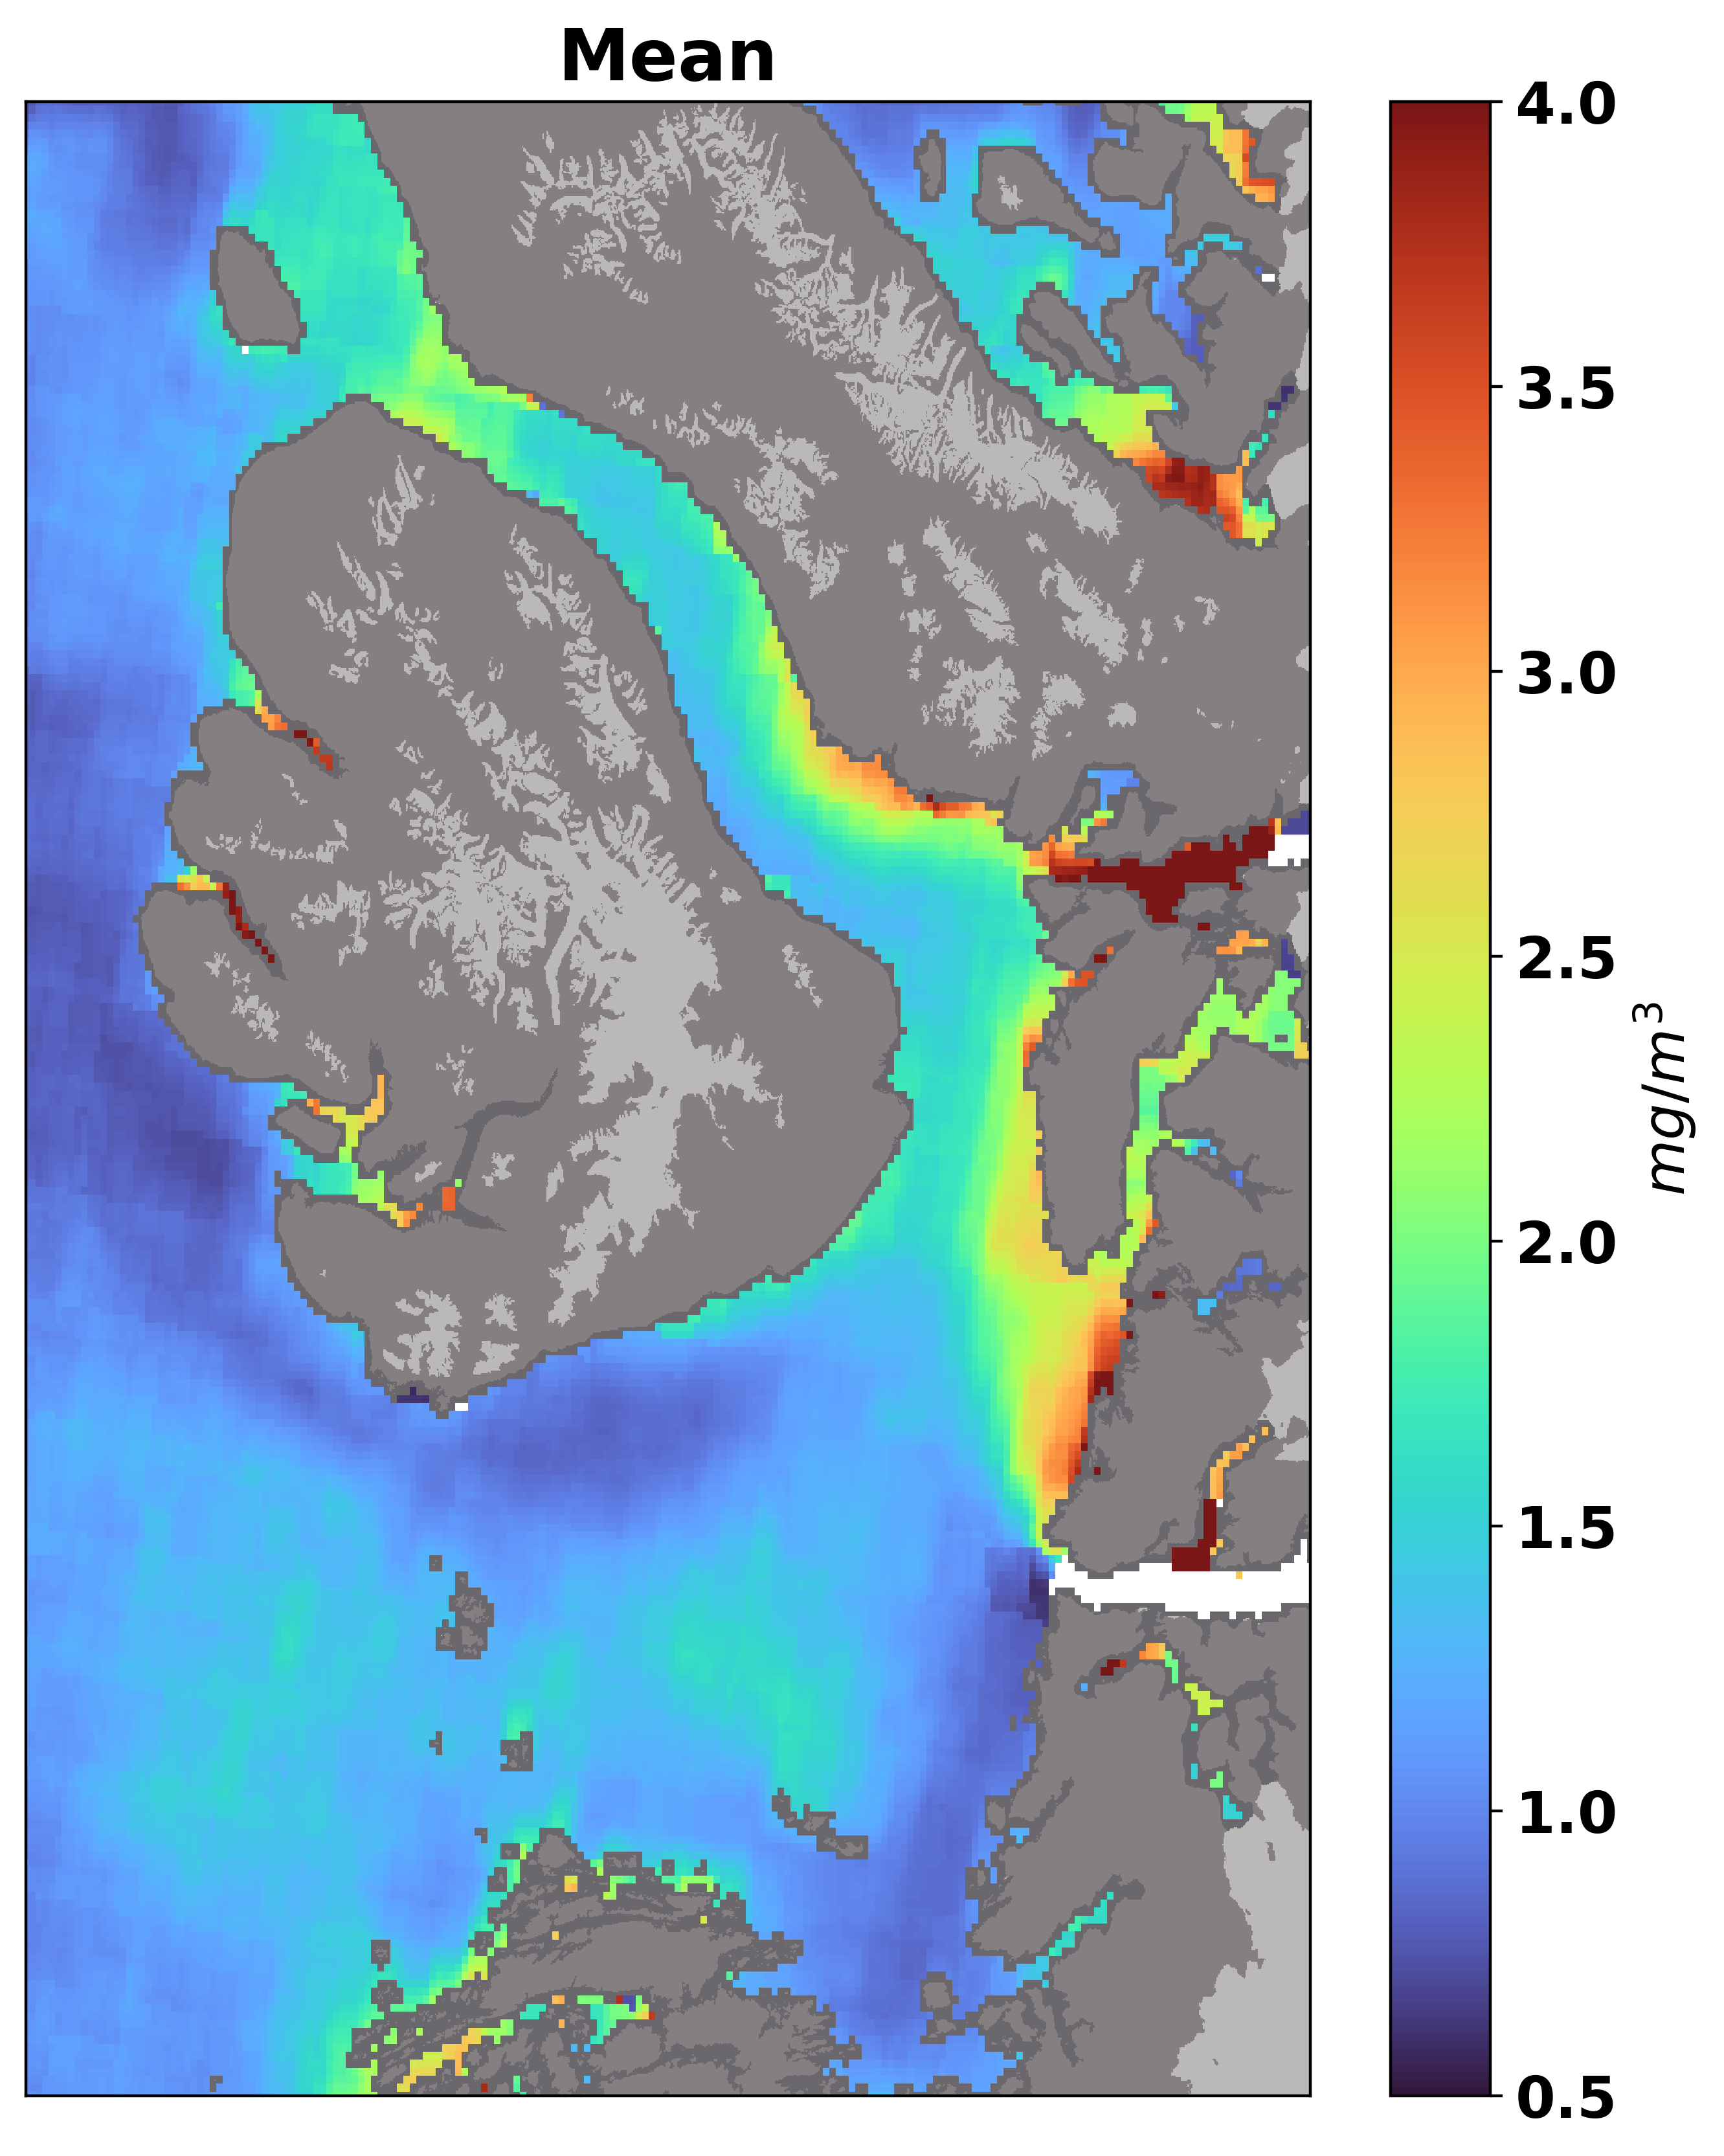

In [48]:
figsize = (8, 10)
plt.figure(figsize=figsize, dpi=400)
plt.pcolormesh(x, y, outline_map, cmap=cmap_outline, alpha=0.9)
plt.pcolormesh(bm_x, bm_y, bm_mask, cmap=cmap_gl, alpha=0.7)

C = plt.pcolormesh(x, y, chlor_masked, cmap=turbo_desat, vmin=0.5, vmax=4)

plt.title("Mean", fontsize=20, weight='bold')

plt.xticks([])
plt.yticks([])

cbar = plt.colorbar(C)
cbar.set_label('$mg/m^3$', size=16, weight='bold')  # Set colorbar label font size and weight
cbar.ax.tick_params(labelsize=16)  # Set tick label font size

# Set color bar tick labels to bold
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")

plt.gca().set_xlim(x.min(), x.max())
plt.gca().set_ylim(y.min(), y.max())

plt.savefig(f"../plots/total_mean_with_map.png", dpi=400, transparent=True)
plt.show()
plt.close()

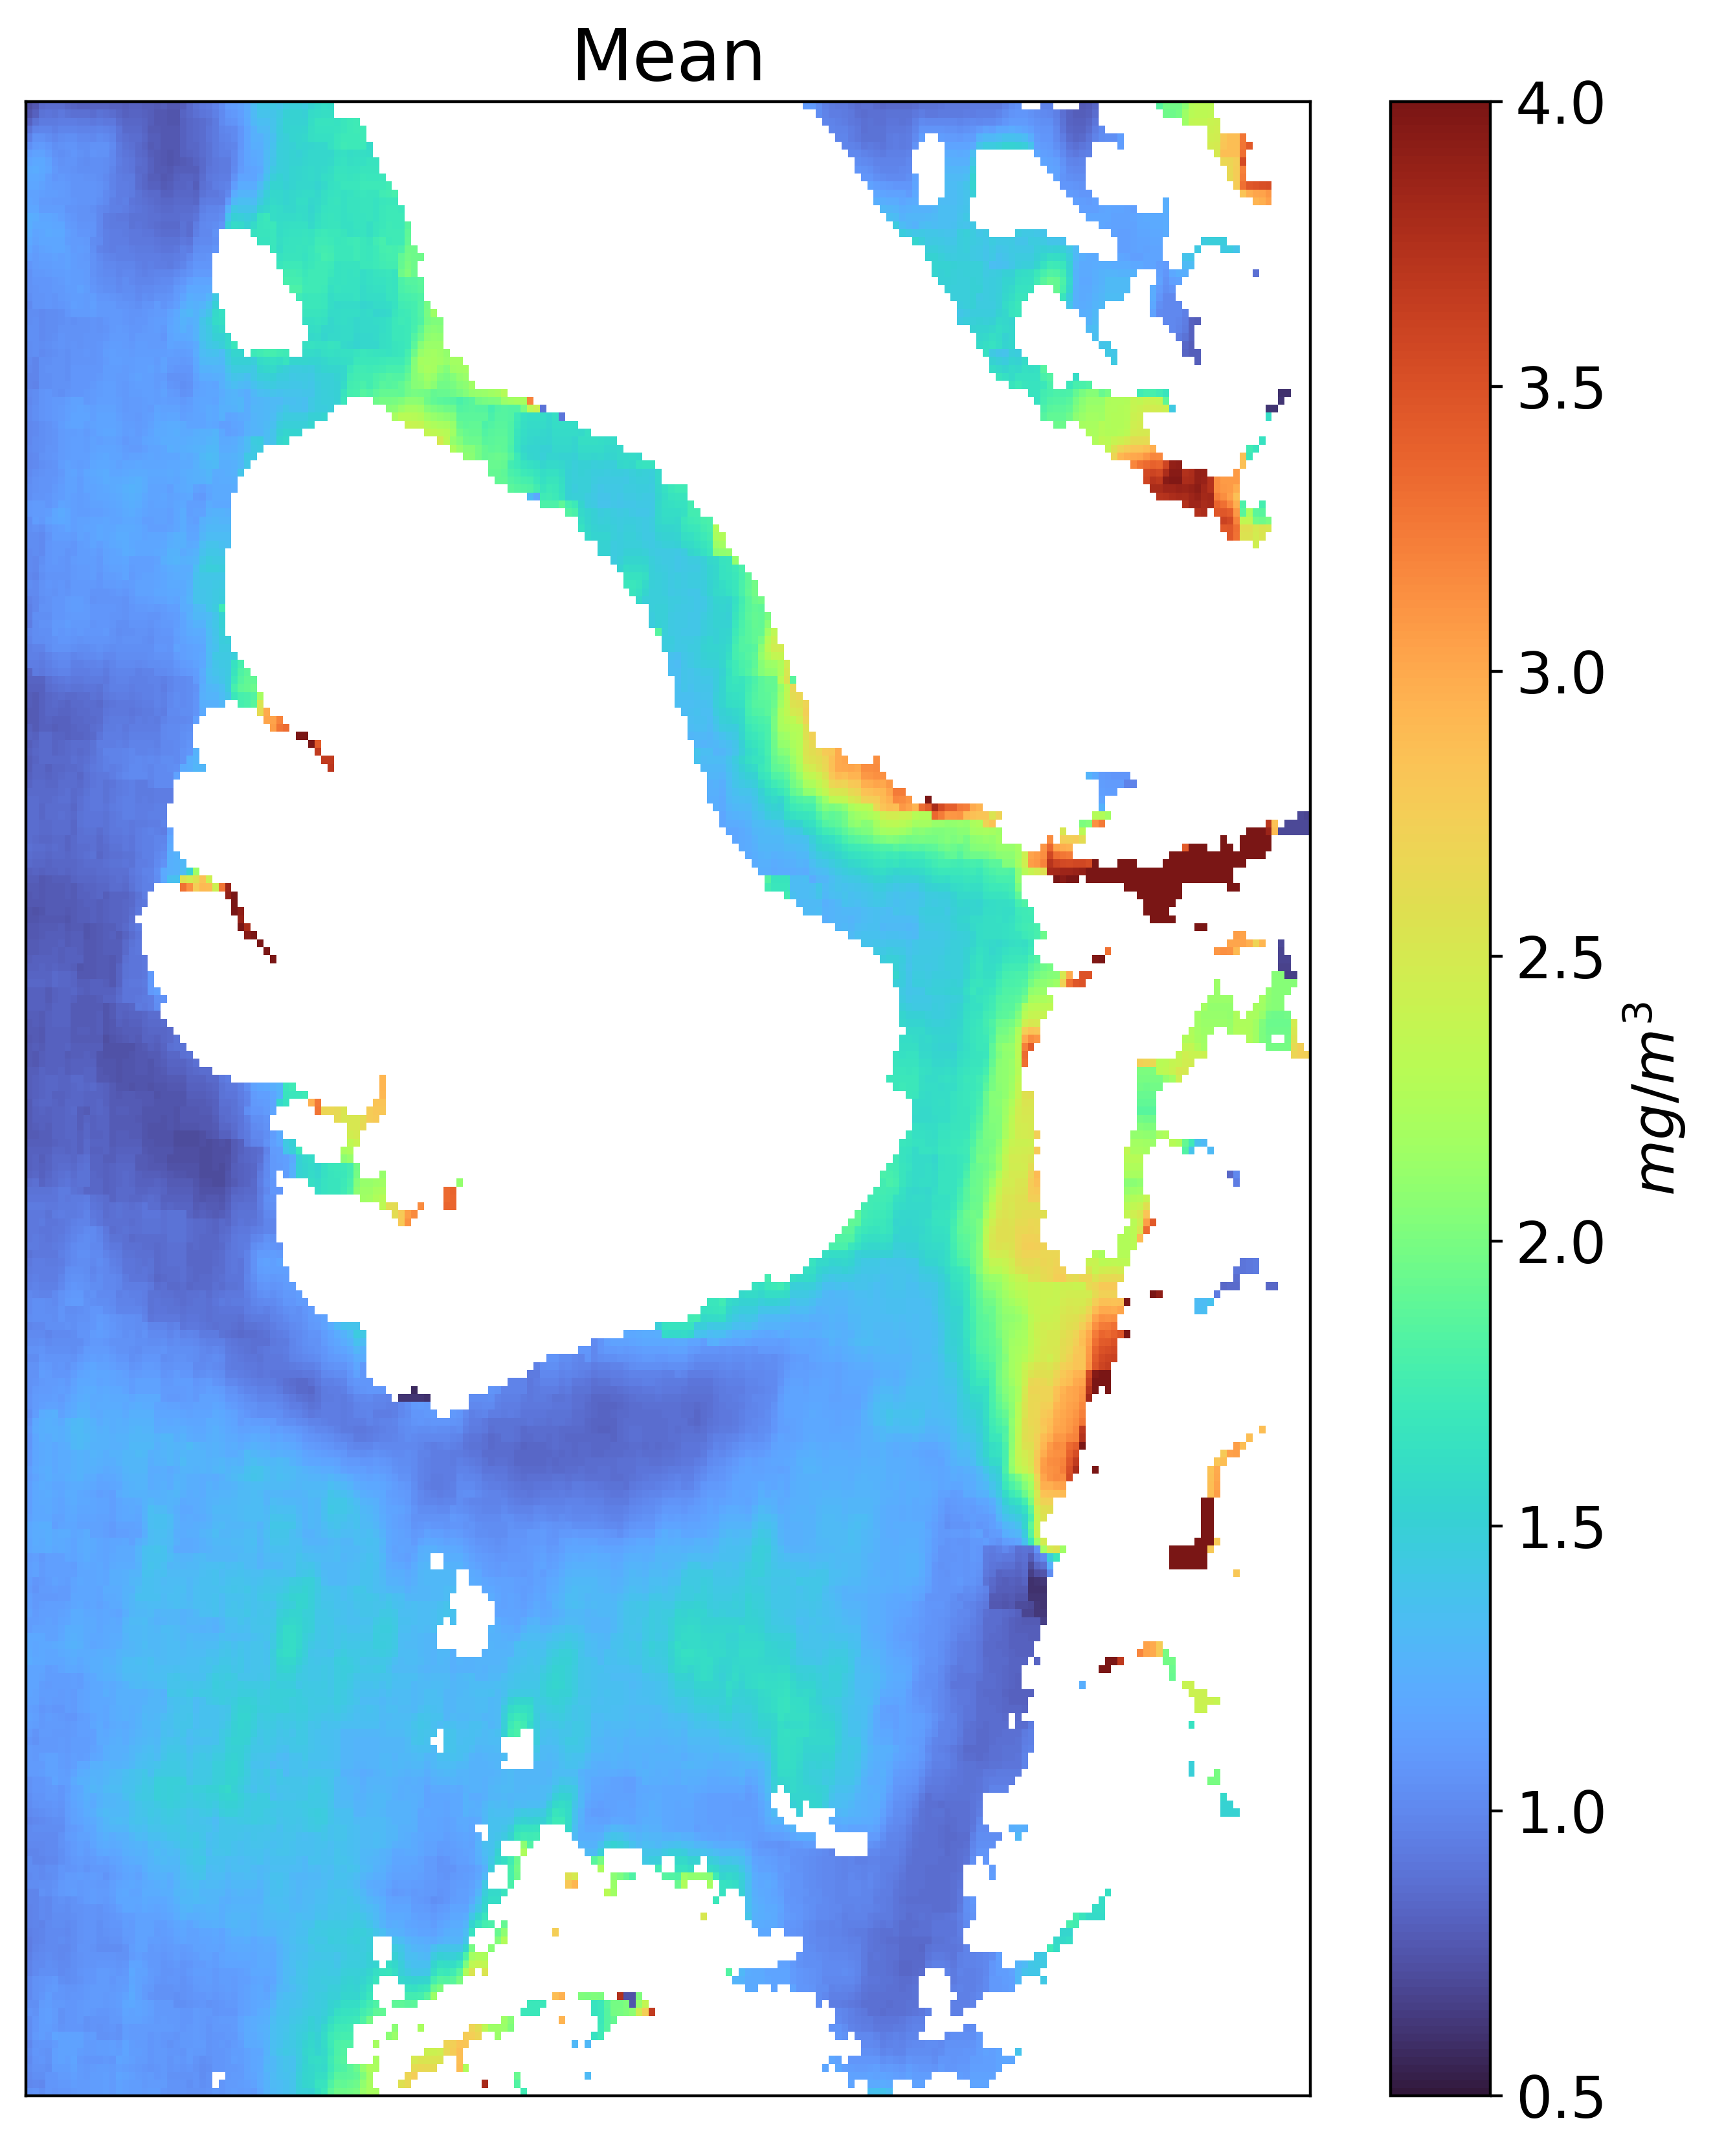

In [51]:
# mean without map mask

cmap_new = colors.LinearSegmentedColormap.from_list("", desaturated_colormap_list)

# reverse the colormap
# cmap_new = cmap_new.reversed()

figsize = (8, 10)
plt.figure(figsize=figsize, dpi=400)
C = plt.pcolormesh(x, y, chlor_masked, cmap=cmap_new, vmin=0.5, vmax=4)
plt.xticks([])
plt.yticks([])
plt.title("Mean", fontsize=20)
cbar = plt.colorbar(C)
cbar.set_label('$mg/m^3$', size=16)  # Set colorbar label font size
cbar.ax.tick_params(labelsize=16)  # Set tick label font size
plt.savefig(f"../plots/total_mean.png", dpi=400, transparent=True)
plt.show()
plt.close()

#### STD

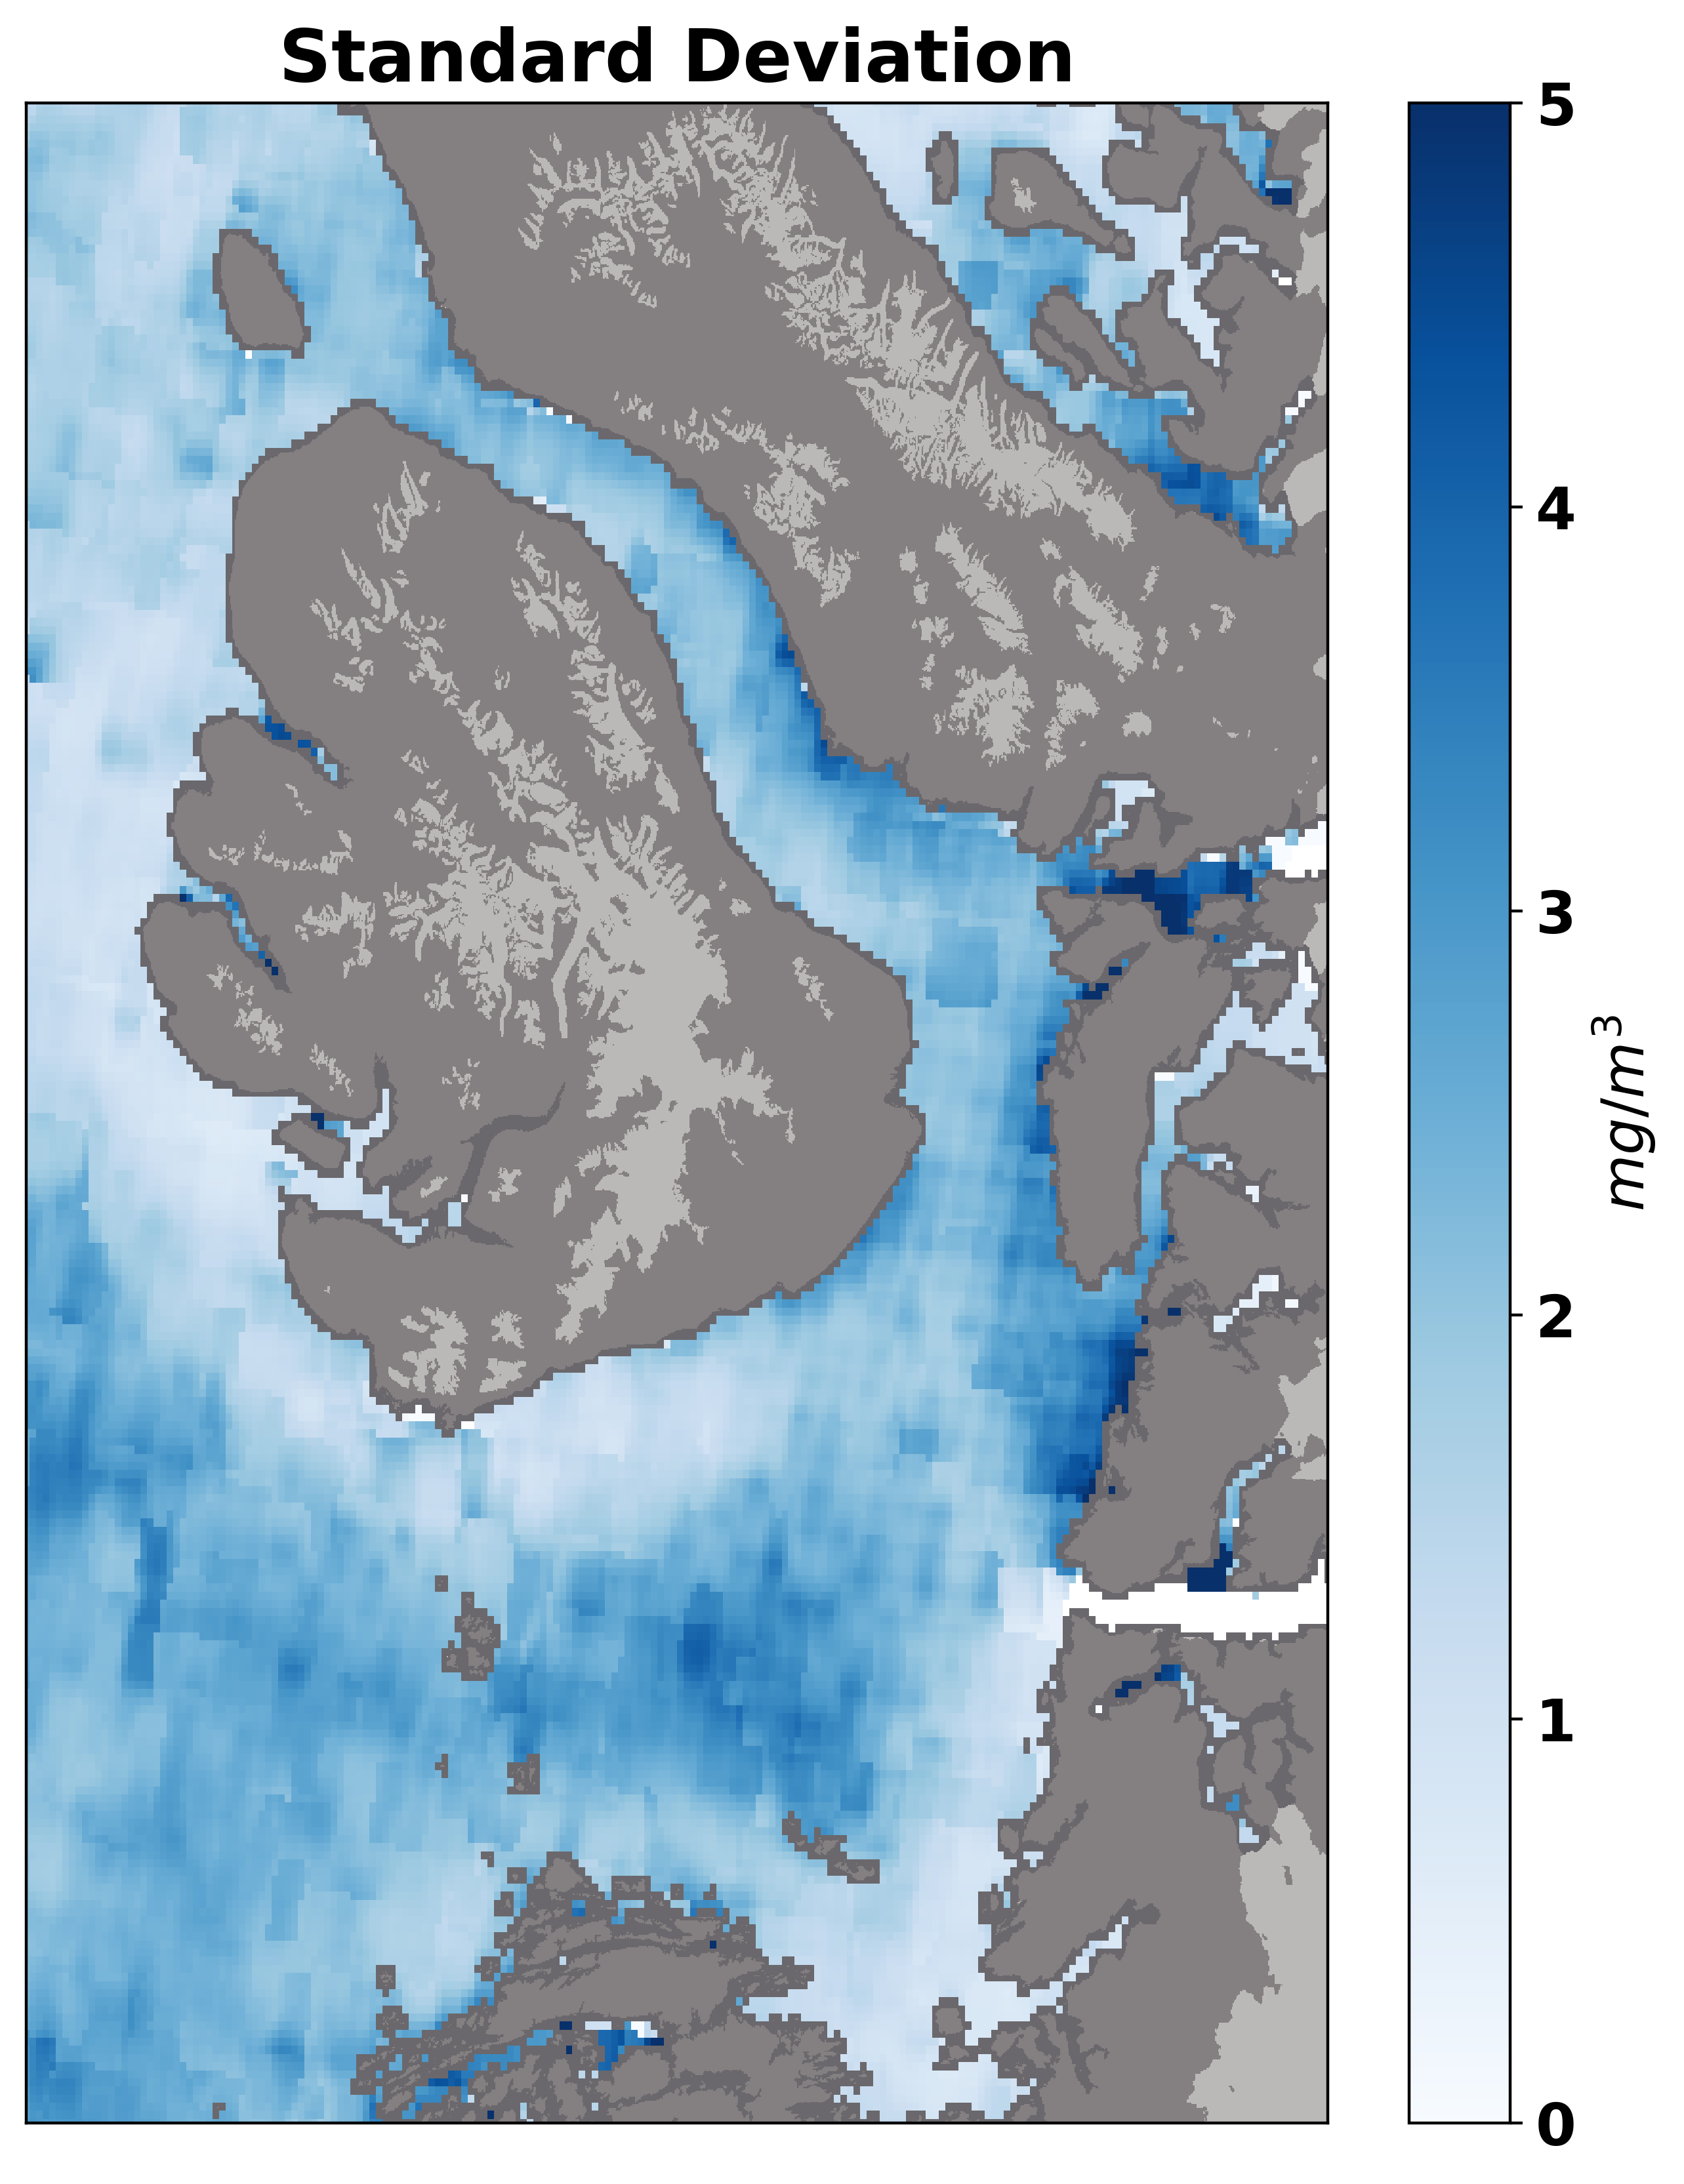

In [49]:
figsize = (8, 10)
plt.figure(figsize=figsize, dpi=400)
plt.pcolormesh(x, y, outline_map, cmap=cmap_outline, alpha=0.9)
plt.pcolormesh(bm_x, bm_y, bm_mask, cmap=cmap_gl, alpha=0.7)
plt.gca().set_xlim(x.min(), x.max())
plt.gca().set_ylim(y.min(), y.max())

C = plt.pcolormesh(x, y, std_masked,  cmap='Blues', vmin=0, vmax=5) 
plt.xticks([])
plt.yticks([])
plt.title("Standard Deviation", fontsize=20, weight='bold')
cbar = plt.colorbar(C)
cbar.set_label('$mg/m^3$', size=16, weight='bold')  # Set colorbar label font size
cbar.ax.tick_params(labelsize=16)  # Set tick label font size

# Set color bar tick labels to bold
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")


plt.savefig(f"../plots/total_std_map.png", dpi=400, transparent=True)
plt.show()
plt.close()

#### Trend

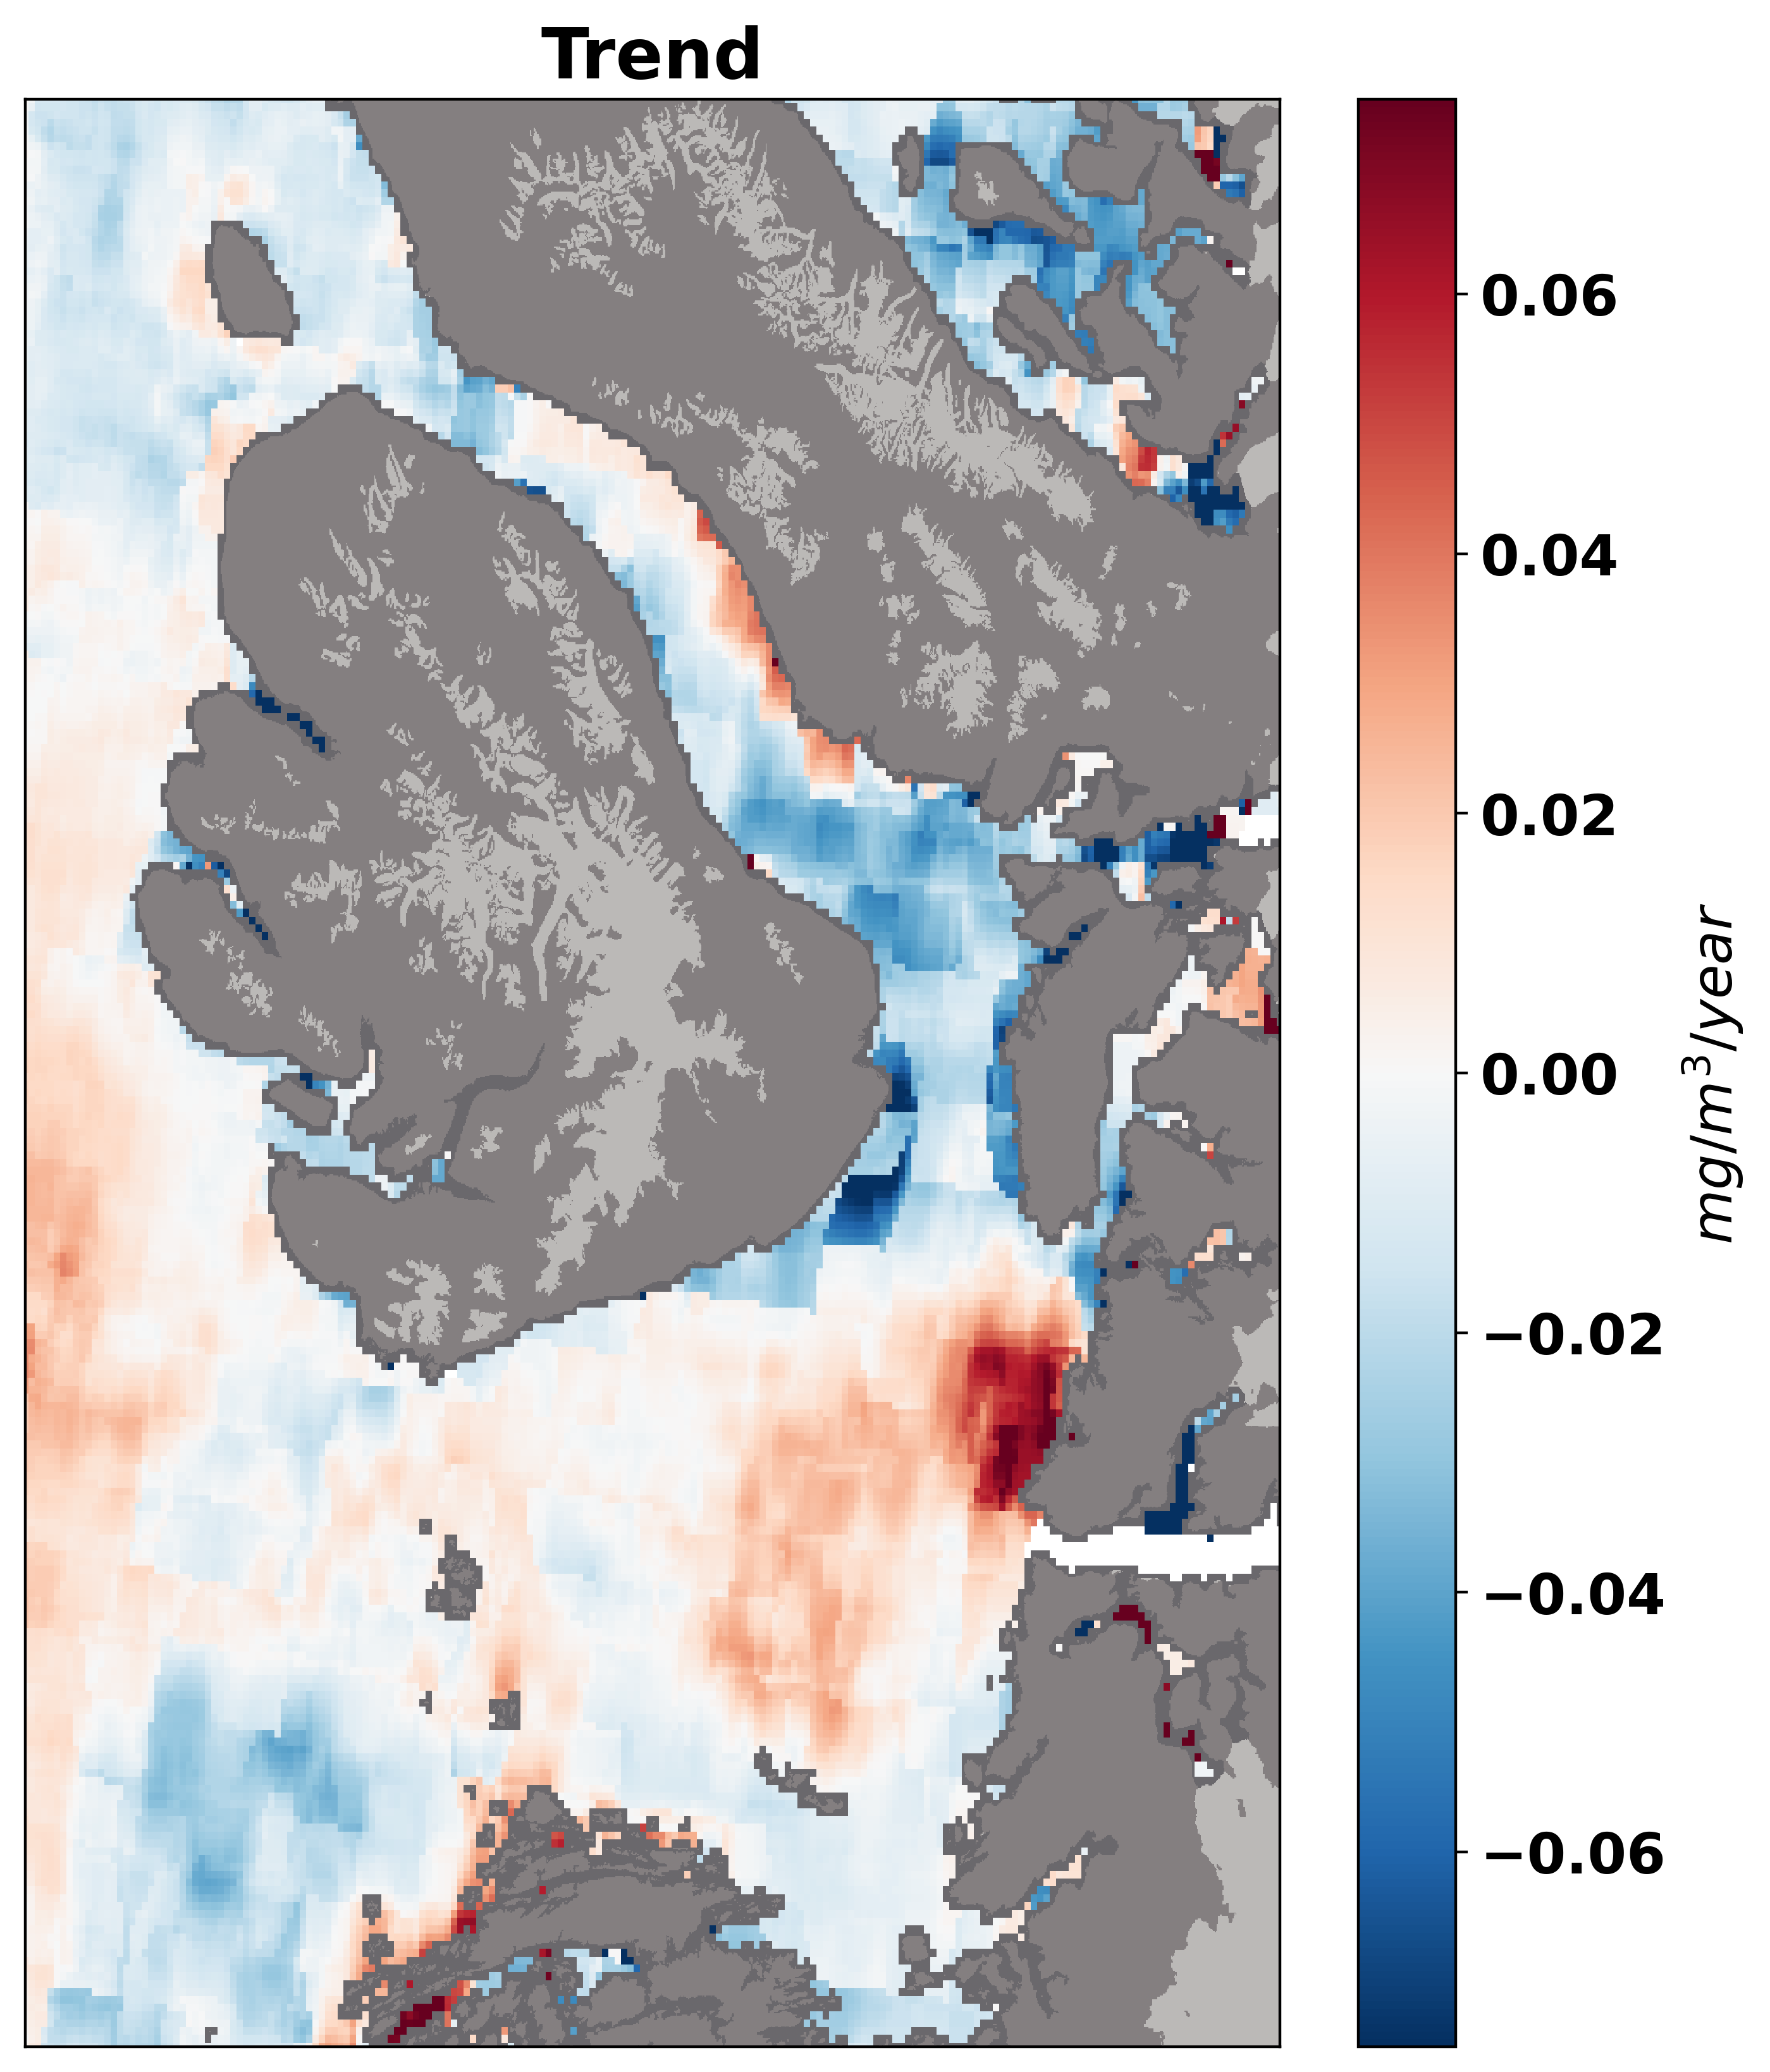

In [50]:
figsize = (8, 10)
plt.figure(figsize=figsize, dpi=400)
plt.pcolormesh(x, y, outline_map, cmap=cmap_outline, alpha=0.9)
plt.pcolormesh(bm_x, bm_y, bm_mask, cmap=cmap_gl, alpha=0.7)
plt.gca().set_xlim(x.min(), x.max())
plt.gca().set_ylim(y.min(), y.max())


C = plt.pcolormesh(x, y, slopes_masked,  cmap='RdBu_r', vmin=-.075, vmax=.075) 
plt.xticks([])
plt.yticks([])
plt.title("Trend", fontsize=20, weight='bold')
cbar = plt.colorbar(C)
cbar.set_label('$mg/m^3/year$', size=16, weight='bold')  # Set colorbar label font size
cbar.ax.tick_params(labelsize=16)  # Set tick label font size

# Set color bar tick labels to bold
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")
    
plt.savefig(f"../plots/total_trend_map.png", dpi=400, transparent=True)
plt.show()
plt.close()

#### RMSE

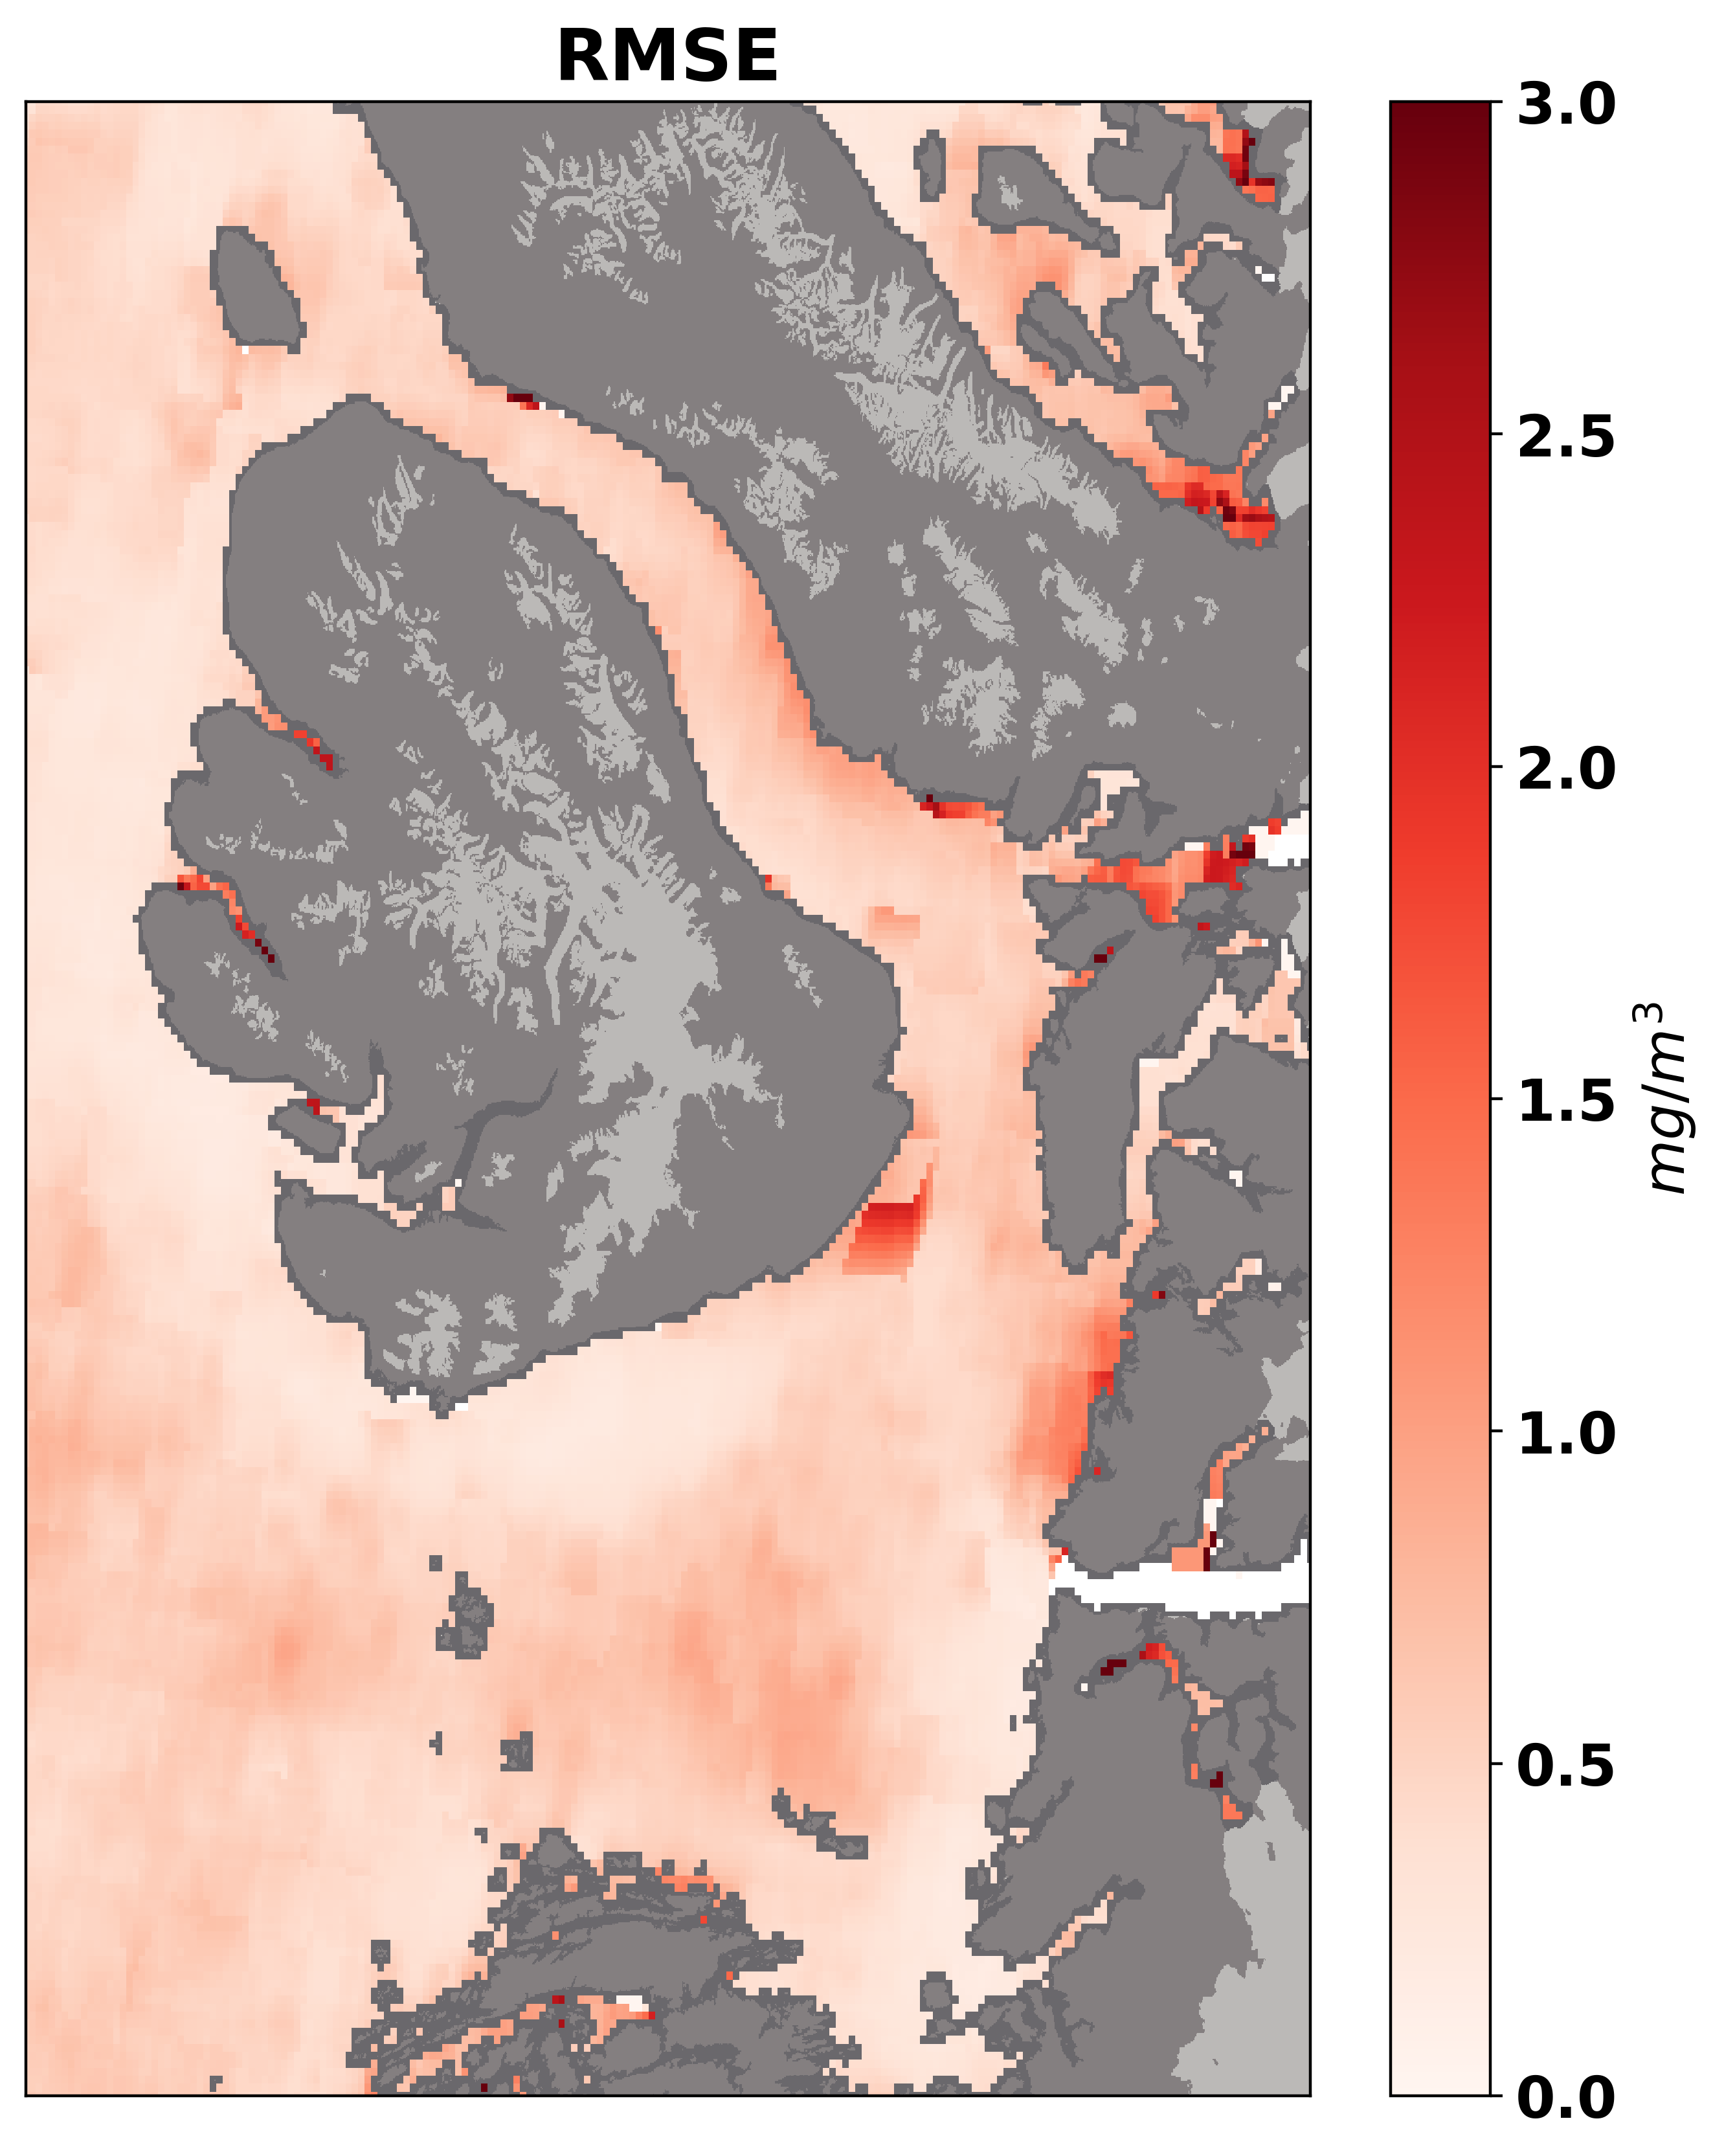

In [51]:
figsize = (8, 10)
plt.figure(figsize=figsize, dpi=400)

plt.pcolormesh(x, y, outline_map, cmap=cmap_outline, alpha=0.9)
plt.pcolormesh(bm_x, bm_y, bm_mask, cmap=cmap_gl, alpha=0.7)
plt.gca().set_xlim(x.min(), x.max())
plt.gca().set_ylim(y.min(), y.max())


C = plt.pcolormesh(x, y, rmse_masked,  cmap='Reds', vmin=0, vmax=3) 
plt.xticks([])
plt.yticks([])
plt.title("RMSE", fontsize=20, weight='bold')
cbar = plt.colorbar(C)
cbar.set_label('$mg/m^3$', size=16, weight='bold')  # Set colorbar label font size
cbar.ax.tick_params(labelsize=16)  # Set tick label font size

# Set color bar tick labels to bold
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_weight("bold")

plt.savefig(f"../plots/total_rmse_map.png", dpi=400, transparent=True)
plt.show()
plt.close()

# Output (save) the masked data
Format the data to be read into QGIS

In [52]:
def output_masked_data(filename, var, data):
    # output_file = 'Chla STD Grid Masked.nc'
    output_file = filename
    resolution = int(x[1]-x[0])

    data_vars = {}
    # data_vars['chlor_a'] = (['y', 'x'], chlor_masked)
    data_vars[var] = (['y', 'x'], data)


    data_vars['projection'] = chr(0)

    dataset = xr.Dataset(data_vars, coords={'y': y, 'x': x})

    dataset['x'].attrs['long_name'] = 'Cartesian x-coordinate'
    dataset['x'].attrs['standard_name'] = 'projection_x_coordinate'
    dataset['x'].attrs['units'] = 'meters'
    dataset['x'].attrs['axis'] = 'X'
    dataset['x'].attrs['coverage_content_type'] = 'coordinate'
    dataset['x'].attrs['valid_min'] = np.min(x)
    dataset['x'].attrs['valid_max'] = np.max(x)
    dataset['x'].attrs['comment'] = 'Projected horizontal coordinates of the grid'

    dataset['y'].attrs['long_name'] = 'Cartesian y-coordinate'
    dataset['y'].attrs['standard_name'] = 'projection_y_coordinate'
    dataset['y'].attrs['units'] = 'meters'
    dataset['y'].attrs['axis'] = 'Y'
    dataset['y'].attrs['coverage_content_type'] = 'coordinate'
    dataset['y'].attrs['valid_min'] = np.min(y)
    dataset['y'].attrs['valid_max'] = np.max(y)
    dataset['y'].attrs['comment'] = 'Projected vertical coordinates of the grid'

    dataset['projection'].attrs['grid_boundary_top_projected_y'] = np.max(y)
    dataset['projection'].attrs['grid_boundary_bottom_projected_y'] = np.min(y)
    dataset['projection'].attrs['grid_boundary_right_projected_x'] = np.max(x)
    dataset['projection'].attrs['grid_boundary_left_projected_x'] = np.min(x)
    dataset['projection'].attrs['parent_grid_cell_row_subset_start'] = int(0.0)
    dataset['projection'].attrs['parent_grid_cell_row_subset_end'] = int(float(len(y)))
    dataset['projection'].attrs['parent_grid_cell_column_subset_start'] = int(0.0)
    dataset['projection'].attrs['parent_grid_cell_column_subset_end'] = int(float(len(x)))
    dataset['projection'].attrs['spatial_ref'] = 'PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",' \
                                                'GEOGCS["WGS 84",' \
                                                'DATUM["WGS_1984",' \
                                                'SPHEROID["WGS 84",6378137,298.257223563,' \
                                                'AUTHORITY["EPSG","7030"]],' \
                                                'AUTHORITY["EPSG","6326"]],' \
                                                'PRIMEM["Greenwich",0,' \
                                                'AUTHORITY["EPSG","8901"]],' \
                                                'UNIT["degree",0.01745329251994328,' \
                                                'AUTHORITY["EPSG","9122"]],' \
                                                'AUTHORITY["EPSG","4326"]],' \
                                                'UNIT["metre",1,' \
                                                'AUTHORITY["EPSG","9001"]],' \
                                                'PROJECTION["Polar_Stereographic"],' \
                                                'PARAMETER["latitude_of_origin",70],' \
                                                'PARAMETER["central_meridian",-45],' \
                                                'PARAMETER["scale_factor",1],' \
                                                'PARAMETER["false_easting",0],' \
                                                'PARAMETER["false_northing",0],' \
                                                'AUTHORITY["EPSG","3413"],' \
                                                'AXIS["X",UNKNOWN],' \
                                                'AXIS["Y",UNKNOWN]]'
    dataset['projection'].attrs['grid_mapping_name'] = "polar_stereographic"
    dataset['projection'].attrs[
        'proj4text'] = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'
    dataset['projection'].attrs['srid'] = 'urn:ogc:def:crs:EPSG::3413'
    dataset['projection'].attrs['GeoTransform'] = str(np.min(x)) + ' ' + str(resolution) + ' 0 ' + str(
        np.max(y)) + ' 0 ' + str(-resolution)
    dataset['projection'].attrs['grid_mapping_name'] = "polar_stereographic"
    dataset['projection'].attrs['latitude_of_projection_origin'] = int(70)
    dataset['projection'].attrs['longitude_of_projection_origin'] = int(-45)
    dataset['projection'].attrs['scaling_factor'] = 1
    dataset['projection'].attrs['false_easting'] = 0.0
    dataset['projection'].attrs['false_northing'] = 0.0
    dataset['projection'].attrs['units'] = "meters"

    dataset.to_netcdf(output_file)

In [53]:
output_masked_data('Chla Mean Grid Masked.nc', 'chla', chlor_masked)
output_masked_data('Chla STD Grid Masked.nc', 'std', std_masked)
output_masked_data('Chla Trend Grid Masked.nc', 'trend', slopes_masked)
output_masked_data('Chla RMSE Grid Masked.nc', 'rmse', rmse_masked)

## Misc. Creating a mean chla concententration file for mapping 
very slow to run but calculates the mean from 2002-2023 for the whole world

In [ ]:
# Get and store the mean through time of modis netcdf files
folder = '/Volumes/Seagate/CHANGES/data_repository/CHL/Quarterly_Stacks/MODIS'
files = glob.glob(os.path.join(folder, '*.nc'))

def get_mean_chla(files):
    # open all the files along the time dimension with xarray
    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested', chunks={'time': 1})

    # Compute the mean along the time dimension lazily
    ds = ds.mean(dim='time')

    # Write the dataset to a new netCDF file
    ds.to_netcdf('/Volumes/Seagate/CHANGES/data_repository/CHL/mean_chla_full.nc', mode='w', compute=True)

# get_mean_chla(files)

### Reproject from 4326 to 3413

In [14]:
def reproject_polygon(polygon_array,inputCRS,outputCRS,x_column=0,y_column=1,run_test = True):

    transformer = Transformer.from_crs('EPSG:' + str(inputCRS), 'EPSG:' + str(outputCRS))

    x2, y2 = transformer.transform(polygon_array[:,y_column], polygon_array[:,x_column])
    x2 = np.array(x2)
    y2 = np.array(y2)

    output_polygon=np.copy(polygon_array)
    output_polygon[:,x_column] = x2
    output_polygon[:,y_column] = y2
    return output_polygon


file_name = '/Volumes/Seagate/CHANGES/data_repository/CHL/total_mean.nc'

ds = nc4.Dataset(file_name)
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
chl_a = ds.variables['chlor_a'][:, :]
ds.close()

min_x_index = np.argmin(np.abs(lon-(-90)))
max_x_index = np.argmin(np.abs(lon-(10)))
max_y_index = np.argmin(np.abs(lat-(55)))
min_y_index = np.argmin(np.abs(lat-(85)))

lon = lon[min_x_index:max_x_index]
lat = lat[min_y_index:max_y_index]
chl_a = chl_a[min_y_index:max_y_index, min_x_index:max_x_index]

Lon, Lat = np.meshgrid(lon, lat)
points = np.column_stack([Lon.ravel(), Lat.ravel()])

points = reproject_polygon(points, 4326, 3413)

x = np.arange(-652925.0, 879625.0, 1000)
y = np.arange(-3384425.0,-632675.0, 1000)
X, Y = np.meshgrid(x,y)

chlor_a = griddata(points, chl_a.ravel(), (X,Y), method='nearest')